In [ ]:
!git clone https://github.com/Near32/ReferentialGym.git ; cd ReferentialGym; git checkout develop-continuous-stimulus-dataset; git pull; git status; pip install -e . 

In [1]:
import ReferentialGym

During importation of MineRLDataset:No module named 'minerl'
Please install minerl if you want to use the MineRLDataset.


### Reproduciability: seed and cudnn benchmark

In [25]:
import torch
import numpy as np
import random 

seed = 10
fast = False 

# Following: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(seed)
if hasattr(torch.backends, "cudnn") and not(fast):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)

## Symbolic Continuous Stimulus Dataset:

In the paper [TODO](todo.link), we are introduced to a dataset of symbolic continuous (as opposed to discrete) stimui which has the particularity of allowing to procedurally generate different number of symbols while maintaining the same shape. Namely, provided a number of factor dimensions $N_{dim}$, it is possible to define however many different number of values $d(i)$ for each factor dimension $i$, thus allowing for a variable number of symboles. 

The stimuli are represented by continuous vectors over $[-1,+1]^{N_{dim}}$, as opposed to one-hot encoded vectors in the usual case when using symbolic stimuli. On factor dimension $i$, the $[-1,+1]$ range is partitioned in $d(i)$ sections, each corresponding to one of the $d(i)$ symbolic values available on this factor dimension. 
Upon sampling of a latent value $l(i)$ for the factor dimension $i$, the continuous stimulus vector's $i$-th dimension is populated with a sample from a corresponding gaussian distribution over the $l(i)$-th partition, $g(i) \sim \mathcal{N}( \mu(i), \sigma(i))$, where $\mu(i)$ is the mean of the gaussian distribution, uniformely sampled to fall within the range of the $l(i)$-th partition, and $\sigma(i)$ is the standard deviation of the gaussian distribution, uniformely sampled over the range $[\frac{ 2 }{ 12 d(i) }, \frac{ 2 }{ 6 d(i) }] $ in order to ensure (i) that the scale of the distribution is large enough, but (ii) not larger than the size of the partition it should fit in.

Similarly to the **3DShapes(PyBullet) dataset**, different viewpoint (or object-centric samples) of the same stimulus can be obtained by sampling from the gaussian distributions. The different object-centric viewpoints are sampled upon dataset creation and the number of samples is parameterised.

N.B.: On the contrary to the 3DShapes(PyBullet) dataset, viewpoints are not organised according to a latent/factor dimension (i.e. from one symbolic object to another, taking the same object-centric sample index **does NOT imply any viewpoint similitude of some sort of the two resulting stimuli**).




In [26]:
nbr_latents=3
min_nbr_values_per_latent=3
max_nbr_values_per_latent=8 #10 
nbr_object_centric_samples=100
shuffle_seed = '40'
train_test_split_strategy = f'combinatorial2-{shuffle_seed}' 

train_dataset = ReferentialGym.datasets.SymbolicContinuousStimulusDataset(
    train=True, 
    transform=None, 
    split_strategy=train_test_split_strategy, 
    nbr_latents=nbr_latents, 
    min_nbr_values_per_latent=min_nbr_values_per_latent, 
    max_nbr_values_per_latent=max_nbr_values_per_latent, 
    nbr_object_centric_samples=nbr_object_centric_samples,
)

test_dataset = ReferentialGym.datasets.SymbolicContinuousStimulusDataset(
    train=False, 
    transform=None, 
    split_strategy=train_test_split_strategy, 
    nbr_latents=nbr_latents, 
    min_nbr_values_per_latent=min_nbr_values_per_latent, 
    max_nbr_values_per_latent=max_nbr_values_per_latent, 
    nbr_object_centric_samples=nbr_object_centric_samples,
    prototype=train_dataset,
)

Split Strategy: combinatorial2-40
Dataset Size: 6600 out of 12000 : 55.0%.
Dataset loaded : OK.
Split Strategy: combinatorial2-40
Dataset Size: 5400 out of 12000 : 45.0%.
Dataset loaded : OK.


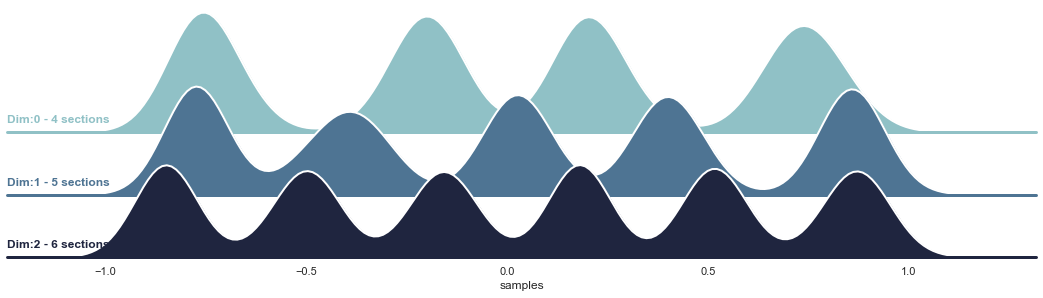

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
dimension = []
samples = []
train = []
for lidx in train_dataset.latent_dims:
    for sidx in train_dataset.latent_dims[lidx]['sections']:
        for oc_value in train_dataset.latent_dims[lidx]['sections'][sidx]['object_centric_samples']:
            dimension.append(f"Dim:{lidx} - {train_dataset.latent_dims[lidx]['size']} sections")
            samples.append(oc_value)
            train.append('train')

for lidx in test_dataset.latent_dims:
    for sidx in test_dataset.latent_dims[lidx]['sections']:
        for oc_value in test_dataset.latent_dims[lidx]['sections'][sidx]['object_centric_samples']:
            dimension.append(f"Dim:{lidx} - {test_dataset.latent_dims[lidx]['size']} sections")
            samples.append(oc_value)
            train.append('test')

df = pd.DataFrame(dict(
    dimension=dimension, 
    samples=samples,
    train=train
))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(nbr_latents, rot=-.25, light=.7)
g = sns.FacetGrid(
    df, 
    row="dimension", 
    hue="dimension", 
    aspect=10, 
    height=1.5, 
    palette=pal
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot, 
    "samples",
    bw_adjust=0.5, 
    clip_on=False,
    fill=True, 
    alpha=1.0, 
    linewidth=1.0
)
g.map(
    sns.kdeplot, 
    "samples", 
    clip_on=False, 
    color="w", 
    lw=2, 
    bw_adjust=.5
)
g.map(
    plt.axhline, 
    y=0, 
    lw=3, 
    clip_on=False
)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "samples")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

{0: 4, 1: 5, 2: 6}


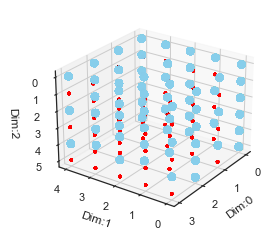

In [28]:
dd = {}

for idx in range(len(train_dataset)):
    latent_repr = train_dataset.getlatentclass(idx)
    for key in train_dataset.latent_dims:
        pos = train_dataset.latent_dims[key]['position']
        if key not in dd: 
            dd[key] = [] 
        dd[key].append(latent_repr[pos])
        #dd['label'].append('train')
        nbr_train = idx+1 

for idx in range(len(test_dataset)):
    latent_repr = test_dataset.getlatentclass(idx)
    for key in test_dataset.latent_dims.keys():
        pos = test_dataset.latent_dims[key]['position']
        if key not in dd: dd[key] = [] 
        dd[key].append(latent_repr[pos])
        #dd['label'].append('test')

df = pd.DataFrame(dd)
#df = pd.DataFrame({'X':range(1,101), 'Y':np.random.rand(100)*15+range(1,101), 'Z':(np.random.randn(100)*15+range(1,101))*2})

#tsne(df.to_numpy(), nbr_train)


variations = {}
for key in dd.keys():
    variations[key] = train_dataset.latent_dims[key]['size']

nbr_lines = variations[0]
nbr_rows = variations[1]

print(variations)

fig = plt.figure()
axes = []
idxcurrentgraph = 0
idxcurrentgraph += 1
ax = fig.add_subplot(projection='3d')
ax.scatter(df[0][:nbr_train], df[1][:nbr_train], df[2][:nbr_train], c='skyblue', s=50)
ax.scatter(df[0][nbr_train:], df[1][nbr_train:], df[2][nbr_train:], c='red', s=5)
#ax.view_init(125, 35)
#ax.view_init(145, 45)
#ax.view_init(145, -135)
ax.view_init(-155, 145)
ax.set_xlabel('Dim:0')
ax.set_ylabel('Dim:1')
ax.set_zlabel('Dim:2')
axes.append(ax)
plt.show()


In [29]:
dd_v = {}

for idx in range(len(train_dataset)):
    #latent_repr = train_dataset[idx]['experiences']
    latent_repr = train_dataset[idx]['exp_latents_values']
    for key in train_dataset.latent_dims:
        pos = train_dataset.latent_dims[key]['position']
        if key not in dd_v: 
            dd_v[key] = [] 
        dd_v[key].append(latent_repr[0,pos].item())
        nbr_train = idx+1 

for idx in range(len(test_dataset)):
    #latent_repr = test_dataset[idx]['experiences']
    latent_repr = test_dataset[idx]['exp_latents_values']
    for key in test_dataset.latent_dims.keys():
        pos = test_dataset.latent_dims[key]['position']
        if key not in dd_v: dd[key] = [] 
        dd_v[key].append(latent_repr[0,pos].item())
        

In [30]:
df_v = pd.DataFrame(dd_v)
df_v.describe()

,0,1,2
count,12000.000000,12000.000000,12000.000000
mean,-0.005309,0.027205,0.009153
std,0.543801,0.576258,0.585163
min,-0.750948,-0.766203,-0.851442
25%,-0.340574,-0.404624,-0.503159
50%,-0.001623,0.030500,0.011656
75%,0.333642,0.417185,0.520295
max,0.732957,0.859167,0.865913


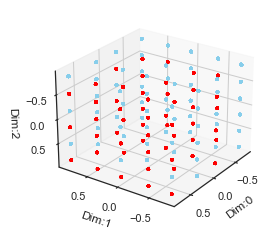

In [31]:
fig = plt.figure()
axes = []
idxcurrentgraph = 0
idxcurrentgraph += 1
ax = fig.add_subplot(projection='3d')
ax.scatter(df_v[0][:nbr_train], df_v[1][:nbr_train], df_v[2][:nbr_train], c='skyblue', s=5)
ax.scatter(df_v[0][nbr_train:], df_v[1][nbr_train:], df_v[2][nbr_train:], c='red', s=5)
#ax.view_init(125, 35)
#ax.view_init(145, 45)
#ax.view_init(145, -135)
ax.view_init(-155, 145)
ax.set_xlabel('Dim:0')
ax.set_ylabel('Dim:1')
ax.set_zlabel('Dim:2')
axes.append(ax)
plt.show()